In [1]:
# Add the root path of the pyqula library
import os ; import sys
try: sys.path.append(os.environ["PYQULAROOT"]) # add the library via environmental variable
except: 
    try: from pyqula import geometry # check if the library is present
    except: # pyqula not installed
        print("pyqula needs to be installed, installing it")
        import subprocess ; subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade","pyqula"])

# some default parameters in matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['font.size'] = 22
plt.rcParams['image.cmap'] = 'coolwarm'


import numpy as np

# Advanced Quantum Materials, session 8: Excitations and impurities in quantum materials

### Contents

### Learning outcomes
- To understand the relation between electronic structure and response function
- To understand the impact of impurities in a metal
- To understand the impact of impurities in a superconductor
- Rationalize lozalization and dellocalization in quasiperiodci models


### It is not necessary to complete all the exercises, you can just focus on those that sound most interesting for you.

## (Exercise) The charge-charge response function
Here we will show the relationship between the electronic structure and the response function

<Figure size 2000x800 with 0 Axes>

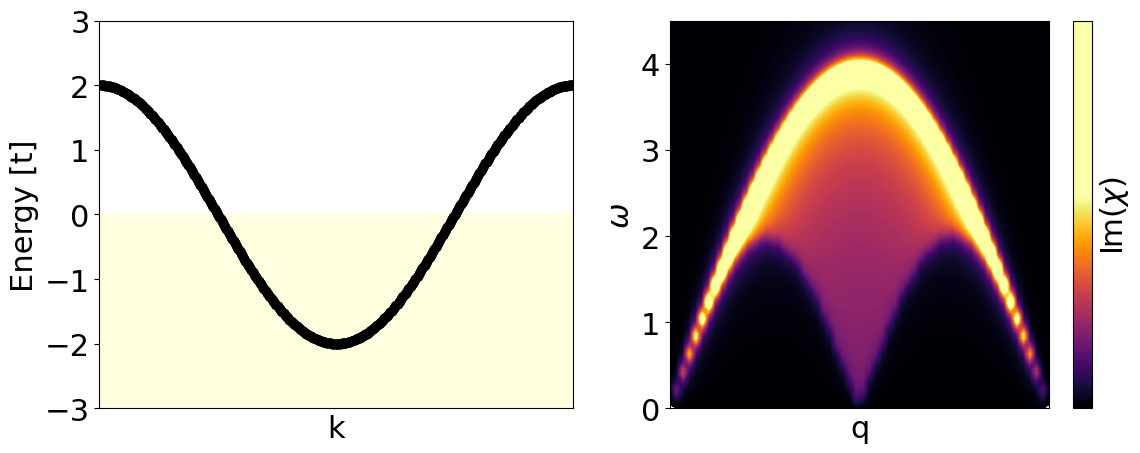

In [2]:
from pyqula import geometry
import numpy as np

fig = plt.figure(figsize=(20,8))

g = geometry.chain()
h = g.get_hamiltonian() # generate Hamiltonian
mu = 0. # chemical potential

h.add_onsite(mu) # shift the chemical potential

energies = np.linspace(0.0,4.5,100) # energies
qs = np.linspace(0.,1.,60) # qvectors
q_arr,e_arr,c_arr = [],[],[]
for q in qs:
    e,c = h.get_chi(energies=energies,q=[q,0.,0.],nk=200)
    c_arr.append(c) # store response
    q_arr.append(q+energies*0.) # store q
    e_arr.append(energies) # store energies

# plot the band structure

fig = plt.figure(figsize=(12,5))
(k,e) = h.get_bands() # compute band structure
plt.subplot(1,2,1)
k = k/np.max(k)
plt.fill_between([0,1],-10,0,color="lightyellow")
plt.scatter(k,e,c="black") ; plt.xlim([0,1]) ; plt.ylim([-3,3])
plt.ylabel("Energy [t]") ; plt.xlabel("k") ; plt.xticks([])
# plot the response
plt.subplot(1,2,2)
c_arr = np.array(c_arr) # to array
plt.contourf(q_arr,e_arr,c_arr.imag,cmap="inferno",levels=200,vmin=0,vmax=4*np.mean(c_arr.imag))
plt.ylabel("$\\omega$") ; plt.xlabel("q") ; plt.xticks([]) ; plt.colorbar(label="Im($\\chi$)",ticks=[])
plt.tight_layout()

### Quiz
- The plot on the right shows the imaginary part of the charge response function. What does it mean?
- Can you predict the instabilities from the right plot. If so, how?
- Change the chemical potential $\mu$, what can you say about the instabilities of the system?

## (Exercise) Impurity in a 1d metal
Let us first look at the modulation of the local density of states in a one-dimensional metal

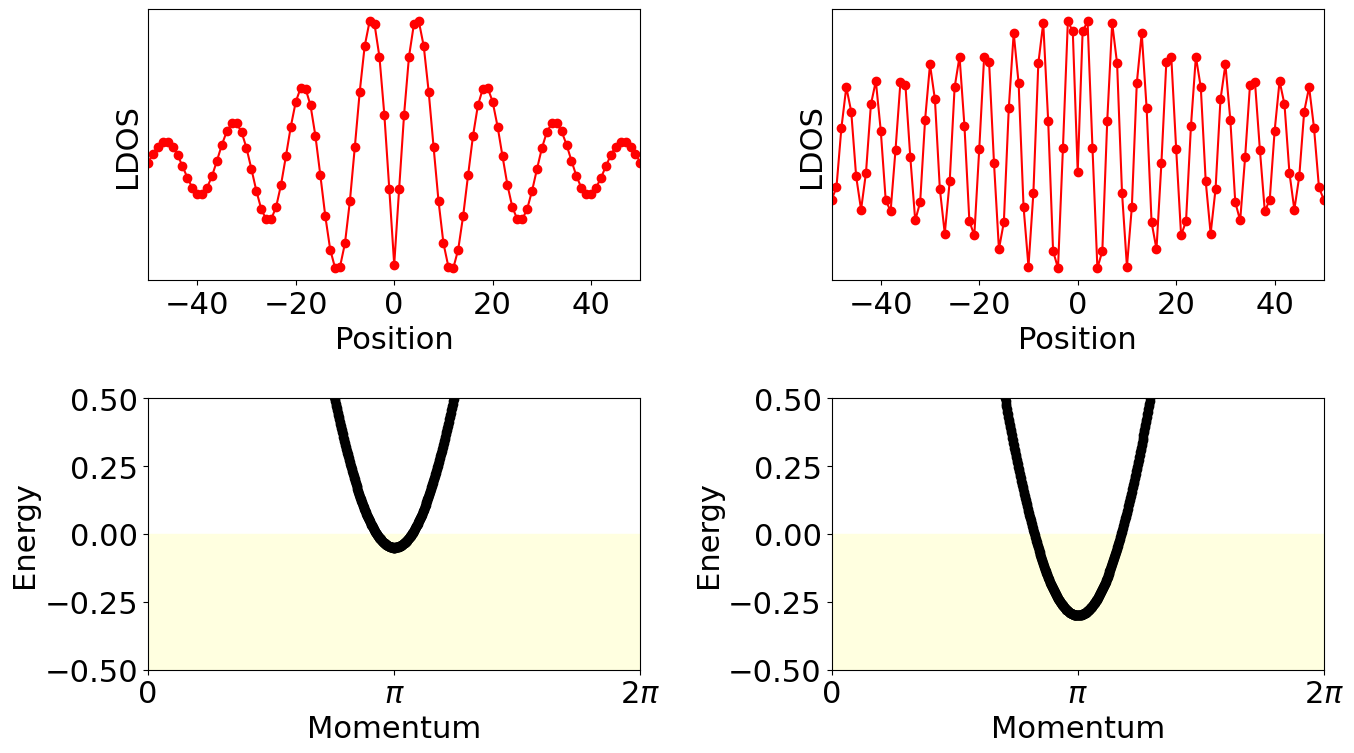

In [3]:
from pyqula import geometry
from pyqula import embedding

fig = plt.figure(figsize=(14,8))


mus = [1.95,1.7] # loop over chemical potentials
imu = 0 # counter for the chemical potential
for mu in mus:
    W = 0.2 # strength of the impurity
    g = geometry.chain() # create geometry of a chain
    h = g.get_hamiltonian(has_spin=False,tij=[1]) # get the Hamiltonian,spinless
    h.add_onsite(mu) # shift the chemical potential
    # first compute the bands of the pristine system
    (k,e) = h.get_bands(nk=1000)
    # now compute the LDOS in the presence of an impurity
    # this uses an special method to compute individual impurities in infinite prstine systems
    hv = h.copy() # copy Hamiltonian to create a defective one
    hv.add_onsite(lambda r: (np.sum((r - g.r[0])**2)<1e-2)*W) # add a defect
    eb = embedding.Embedding(h,m=hv) # create an embedding object
    (x,y,d) = eb.get_ldos(nsuper=101,energy=0.,delta=1e-2,nk=400) # compute LDOS
    # and plot everything
    plt.subplot(2,2,imu+1)
    # plot the LDOS with an impurity
    plt.plot(x,d,marker="o",c="red")
    plt.xlim([min(x),max(x)])
    plt.yticks([]) ; plt.xlabel("Position") ; plt.ylabel("LDOS")
 
    plt.subplot(2,2,imu+3)
    # plot the pristine band structure
    k = k/max(k) # normlaize
    plt.xlim([min(k),max(k)]) ; plt.ylim(-0.5,0.5)
    plt.fill_between([0,1],-10,0,color="lightyellow")
    plt.scatter(k,e,c="black")
    plt.xticks([0,0.5,1],labels=["0","$\\pi$","2$\\pi$"]) ; plt.xlabel("Momentum") ; plt.ylabel("Energy")
    imu += 1
    
plt.tight_layout()

### Quiz
- Why is the local density of states oscillating around the impurity?
- Why does the wavelength of the oscillation depend on the chemical potential?
- Change the chemical potential, how do the oscillations change? Can you predict the wavelength from the band structure?

## (Exercise) Impurities in a 2d metal
We will now see how a 2d metal behaves in the presence of an impurity

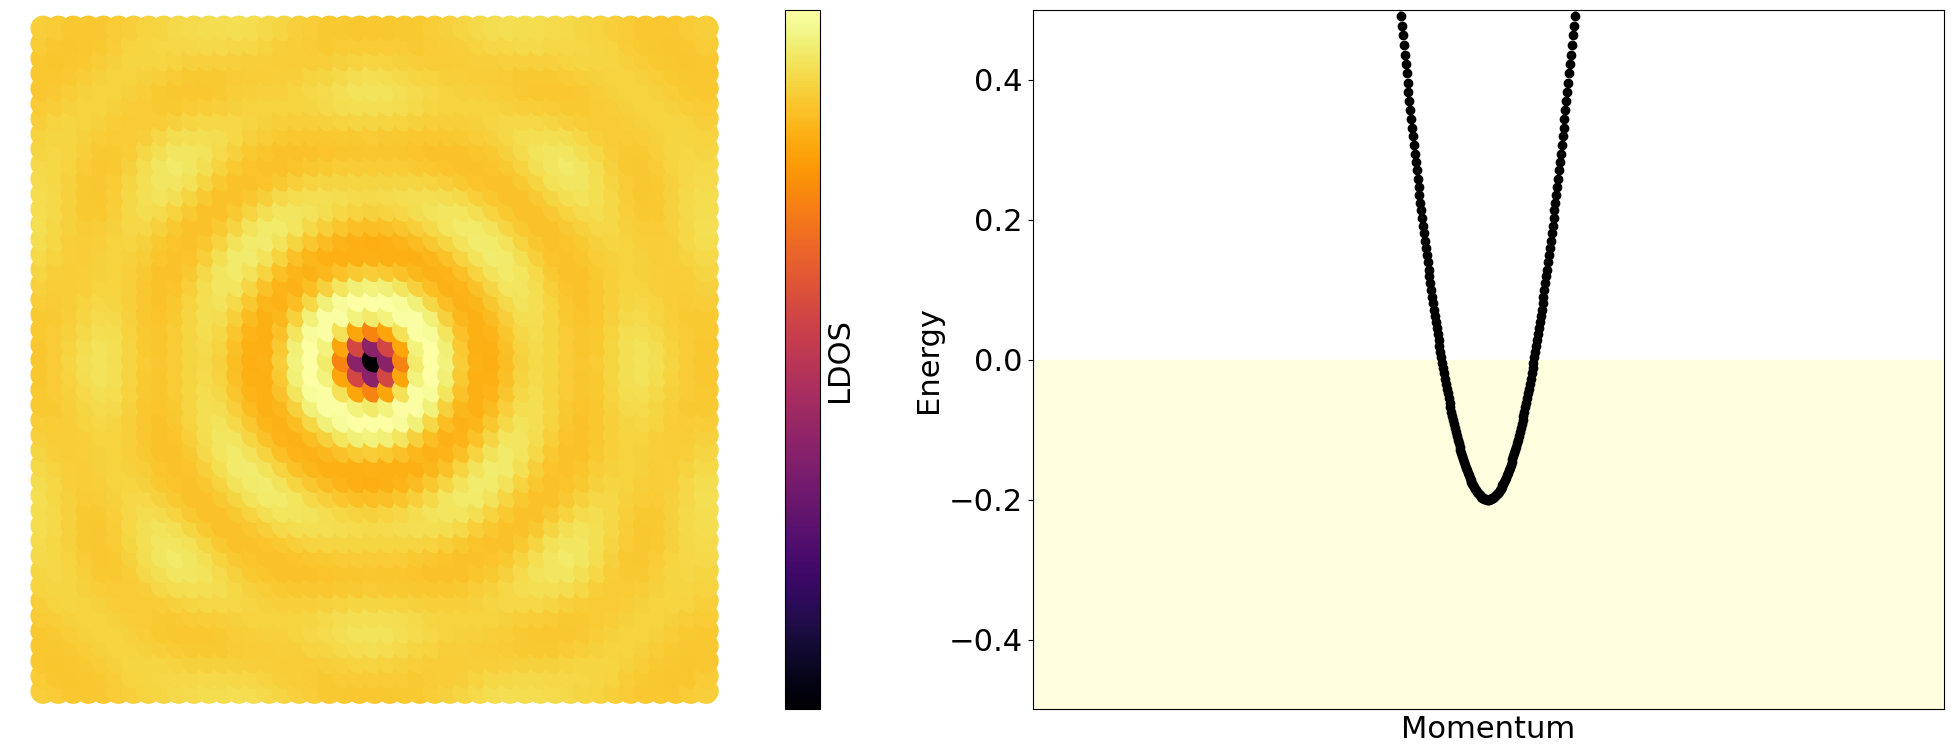

In [4]:
from pyqula import geometry
from pyqula import embedding


fig = plt.figure(figsize=(20,8))

mu = 3.8 # chemical potential
W = 10 # strength of the impurity
g = geometry.square_lattice() # create geometry of a chain
h = g.get_hamiltonian(has_spin=False) # get the Hamiltonian,spinless
h.add_onsite(mu) # shift the chemical potential

# firs compute the band structure of the pristine system
(k,e) = h.get_bands(nk=1000)

# now compute the LDOS in the presence of an impurity
# this uses an special method to compute individual impurities in infinite prstine systems

hv = h.copy() # copy Hamiltonian to create a defective one
hv.add_onsite(lambda r: (np.sum((r - g.r[0])**2)<1e-2)*W) # add a defect
eb = embedding.Embedding(h,m=hv) # create an embedding object
NS = 45 # number of supercells
(x,y,d) = eb.get_ldos(nsuper=NS,energy=0.,delta=1e-2,nk=100) # compute LDOS
 
# now plot the LDOS with an impurity
plt.subplot(1,2,1)
plt.scatter(x,y,c=d,marker="o",cmap="inferno",s=300)
xy = NS/3. # maximum range
plt.xlim([-xy,xy]) ; plt.ylim([-xy,xy])
plt.yticks([]) ; plt.xticks([]); plt.xlabel("y") ; plt.ylabel("x") ; plt.axis("equal") ; plt.axis("off")
plt.colorbar(ticks=[],label="LDOS")

# now plot the pristine band structure
plt.subplot(1,2,2)
k = k/max(k) # normalize
plt.xlim([min(k),max(k)]) ; plt.ylim(-0.5,0.5)
plt.fill_between([0,1],-10,0,color="lightyellow")
plt.scatter(k,e,c="black")
plt.xticks([]) ; plt.xlabel("Momentum") ; plt.ylabel("Energy")
imu += 1
    
plt.tight_layout()

### Quiz
- What is the origin of the oscillations in the LDOS?
- If you change the chamical potential, how do the oscillations change?
- Can you predict the wavelength of the oscillations from the band structure?

# Impurity in an electronic insulator
We will now see how an impurity affects a 1D insulator

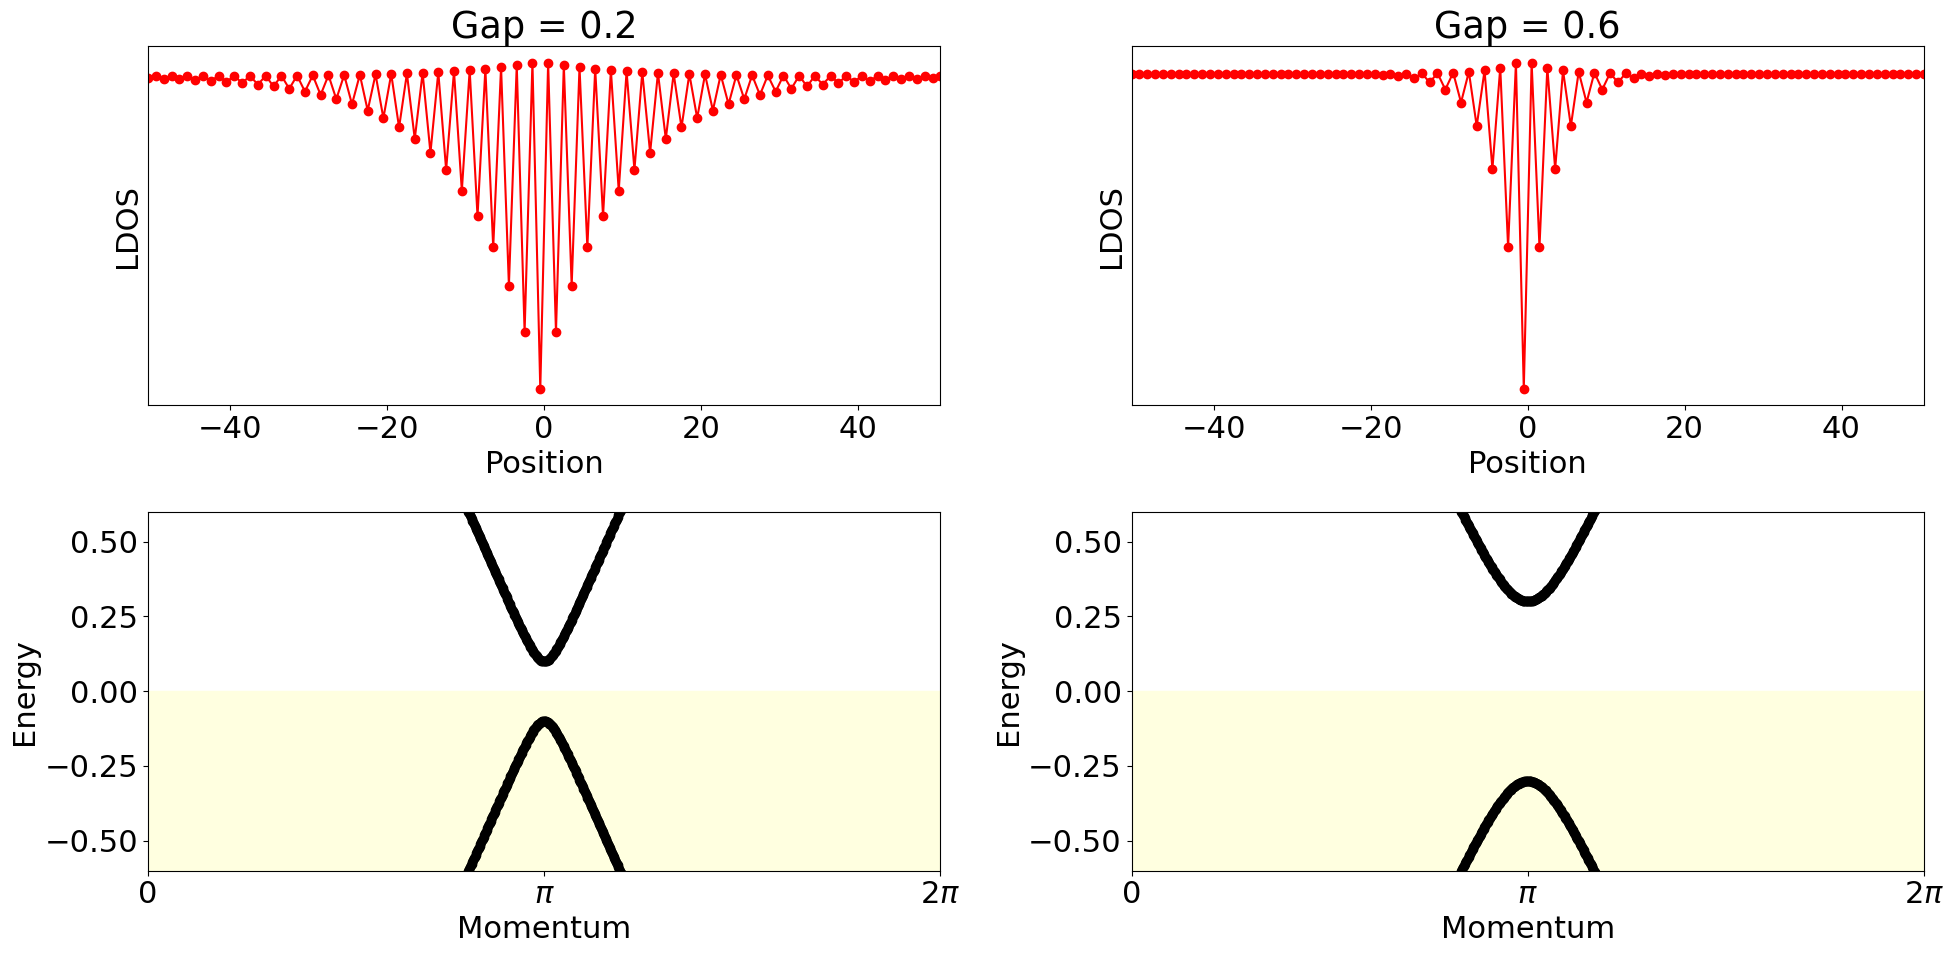

In [5]:
from pyqula import geometry
from pyqula import embedding

fig = plt.figure(figsize=(20,10))


gaps = [0.1,0.3] # loop over gaps
imu = 0 # counter for the chemical potential
for gap in gaps:
    W = 0.2 # strength of the impurity
    g = geometry.bichain() # create geometry of a chain
    h = g.get_hamiltonian(has_spin=False,tij=[1]) # get the Hamiltonian,spinless
#    h.add_onsite(mu) # shift the chemical potential
    h.add_sublattice_imbalance(gap)
    # first compute the bands of the pristine system
    (k,e) = h.get_bands(nk=1000)
    # now compute the LDOS in the presence of an impurity
    # this uses an special method to compute individual impurities in infinite prstine systems
    hv = h.copy() # copy Hamiltonian to create a defective one
    hv.add_onsite(lambda r: (np.sum((r - g.r[0])**2)<1e-2)*W) # add a defect
    eb = embedding.Embedding(h,m=hv) # create an embedding object
    (x,y,d) = eb.get_ldos(nsuper=51,energy=0.,delta=1e-2,nk=400) # compute LDOS
    # and plot everything
    plt.subplot(2,2,imu+1) ; plt.title("Gap = "+str(2*gap))
    # plot the LDOS with an impurity
    plt.plot(x,d,marker="o",c="red")
    plt.xlim([min(x),max(x)])
    plt.yticks([]) ; plt.xlabel("Position") ; plt.ylabel("LDOS")
 
    plt.subplot(2,2,imu+3)
    # plot the pristine band structure
    k = k/max(k) # normlaize
    plt.xlim([min(k),max(k)]) ; plt.ylim(-2*max(gaps),2*max(gaps))
    plt.fill_between([0,1],-10,0,color="lightyellow")
    plt.scatter(k,e,c="black")
    plt.xticks([0,0.5,1],labels=["0","$\\pi$","2$\\pi$"]) ; plt.xlabel("Momentum") ; plt.ylabel("Energy")
    imu += 1
    
plt.tight_layout()

### Quiz
- Why does the LDOS now converge very fast to the unifrom limit?
- Why does the LDOS on the right converge faster to the uniform limit than the case on the left?
- Increase the value of the gap, what 

# Magnetic impurities in a conventional superconductor
We will now see how magnetic impurities in a superconductor create in-gap states

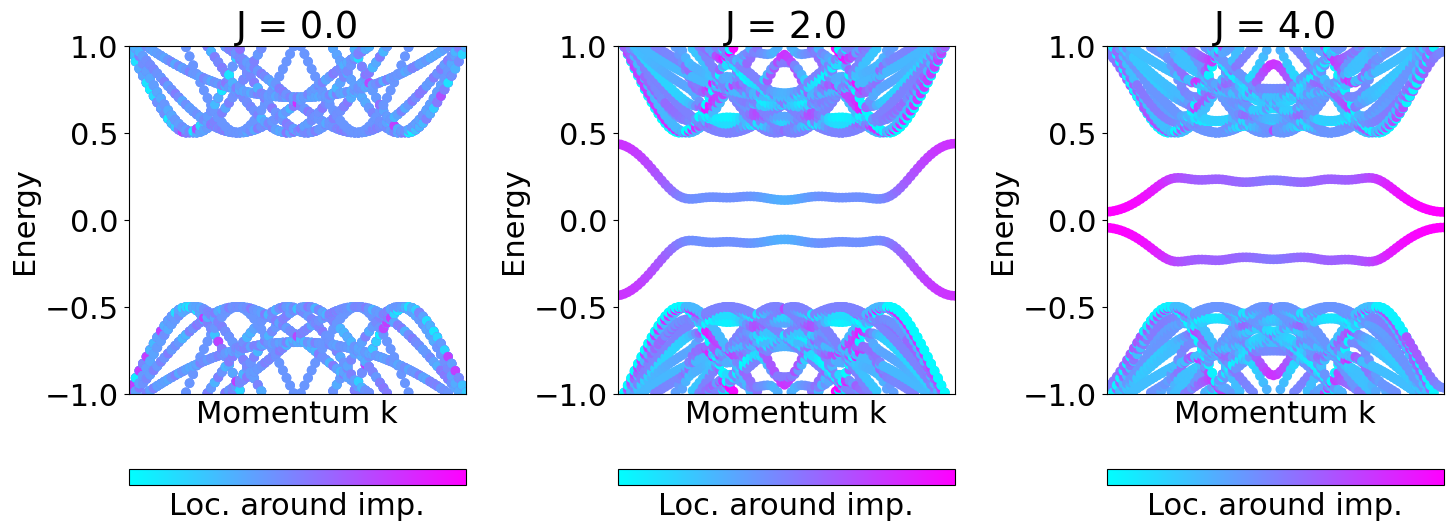

In [6]:
from pyqula import geometry, potentials
g = geometry.triangular_lattice() # take a triangular lattice
N = 7
g = g.get_supercell(N) # make a supercell
h = g.get_hamiltonian() # generate Hamiltonian
h.turn_dense()
delta = 5e-1 # pairing
h.add_swave(delta) # add swave superconductivity 

fig = plt.figure(figsize=(15,6))

pot = potentials.impurity(g.r[0],v=1.0) # potential for an impurity
nns = g.get_connections()[0] # get NN of site 0
NNpot = sum([potentials.impurity(g.r[i],v=1.0) for i in nns]) # potential for an impurity
# redefine the operator so that electron and hole componetns contribute equally
NNpot = h.get_operator(NNpot)*h.get_operator("electron") - h.get_operator(NNpot)*h.get_operator("hole")

def plot_bands(h):
    (ks,es,cs) = h.get_bands(operator=NNpot,nk=100)
    ewin = 1. # energy window to plot
    es,ks,cs = es[np.abs(es)<ewin],ks[np.abs(es)<ewin],cs[np.abs(es)<ewin]
    plt.scatter(ks,es,c=cs,cmap="cool")
    plt.ylabel("Energy") ; plt.xlabel("Momentum k") 
    plt.colorbar(ticks=[],label="Loc. around imp.",orientation="horizontal")
    plt.ylim([-ewin,ewin]) ; plt.xticks([]) ; plt.xlim([min(ks),max(ks)])
    
Js = [0.,2.,4.] # exchange impurity potentials
nv = len(Js)
iv = 0
for J in Js:
    hi = h.copy() # make a copy
    hi.add_exchange(lambda r: [0.,0.,J*pot(r)]) # add exchange impurity potential
    plt.subplot(1,nv,iv+1) ; iv += 1 ; plt.title("J = "+str(J))
    plot_bands(hi) # make the plot

plt.tight_layout()

### Quiz
- Which one of the bands is the impurity band?
- Make the supercell bigger. What do you observa and why?
- Make the exchange coupling even bigger, what do you observe, and why?

## (Exercise) Single magnetic impurity in a superconductor
Now we will see how a magnetic impurity in a superconductor creates a bound state

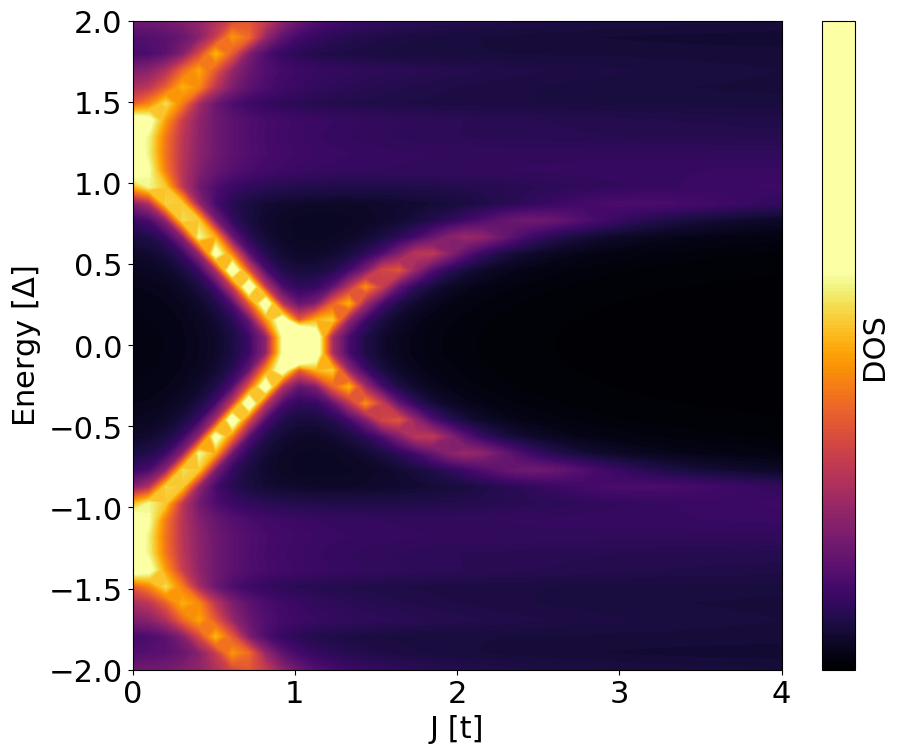

In [7]:
from pyqula import geometry
from pyqula import embedding
import numpy as np

fig = plt.figure(figsize=(10,8))

g = geometry.chain() # create geometry
g.get_supercell(3) # three sites per unit cell
J_arr,e_arr,d_arr = [],[],[] # empty list
Js = np.linspace(0.,4.0,40) # exchanges to consider
delta= 0.2 # superconducting order
energies = np.linspace(-2*delta,2*delta,40) # energies

# loop over the strength of the non-magnetic impurity
for J in Js: # loop over exchange
    h = g.get_hamiltonian() # get the Hamiltonian,spinless
    h.add_onsite(1.8) # shift chemical potential
    h.add_swave(delta) # add s-wave superconductivity
    hv = h.copy() # copy Hamiltonian to create a defective one
    # add magnetic site
    hv.add_exchange(lambda r: [0.,0.,(np.sum((r - g.r[0])**2)<1e-2)*J])
    eb = embedding.Embedding(h,m=hv) # create an embedding object
    d = [eb.dos(nsuper=2,delta=delta/10,energy=ei) for ei in energies] # compute DOS
    d = np.array(d) #; d = d/np.max(d) # normalize
    J_arr.append(J + energies*0.) # store exchange
    d_arr.append(d) # store DOS
    e_arr.append(energies) # store energies
    
plt.contourf(J_arr,np.array(e_arr)/delta,d_arr,cmap="inferno",vmax=5*np.mean(d_arr),levels=200)
plt.xlim([min(Js),max(Js)]); plt.ylim([-2,2])
plt.xlabel("J [t]") ; plt.ylabel("Energy [$ \\Delta $]")
plt.colorbar(label="DOS",ticks=[])
plt.tight_layout()

### Quiz
- Which point corresponds to a system without an impurity?
- Which does a magnetic impurity create an in-gap state?
- Change the chemical potential of the chain, does the previous behavior change? Explain why.
- The in-gap mode dissappears for a very strong impurity. Explain why.

## (Exercise) Extended and localized states in quasicrystals
We will now see how extended and localized states can appear in a quasicrystal

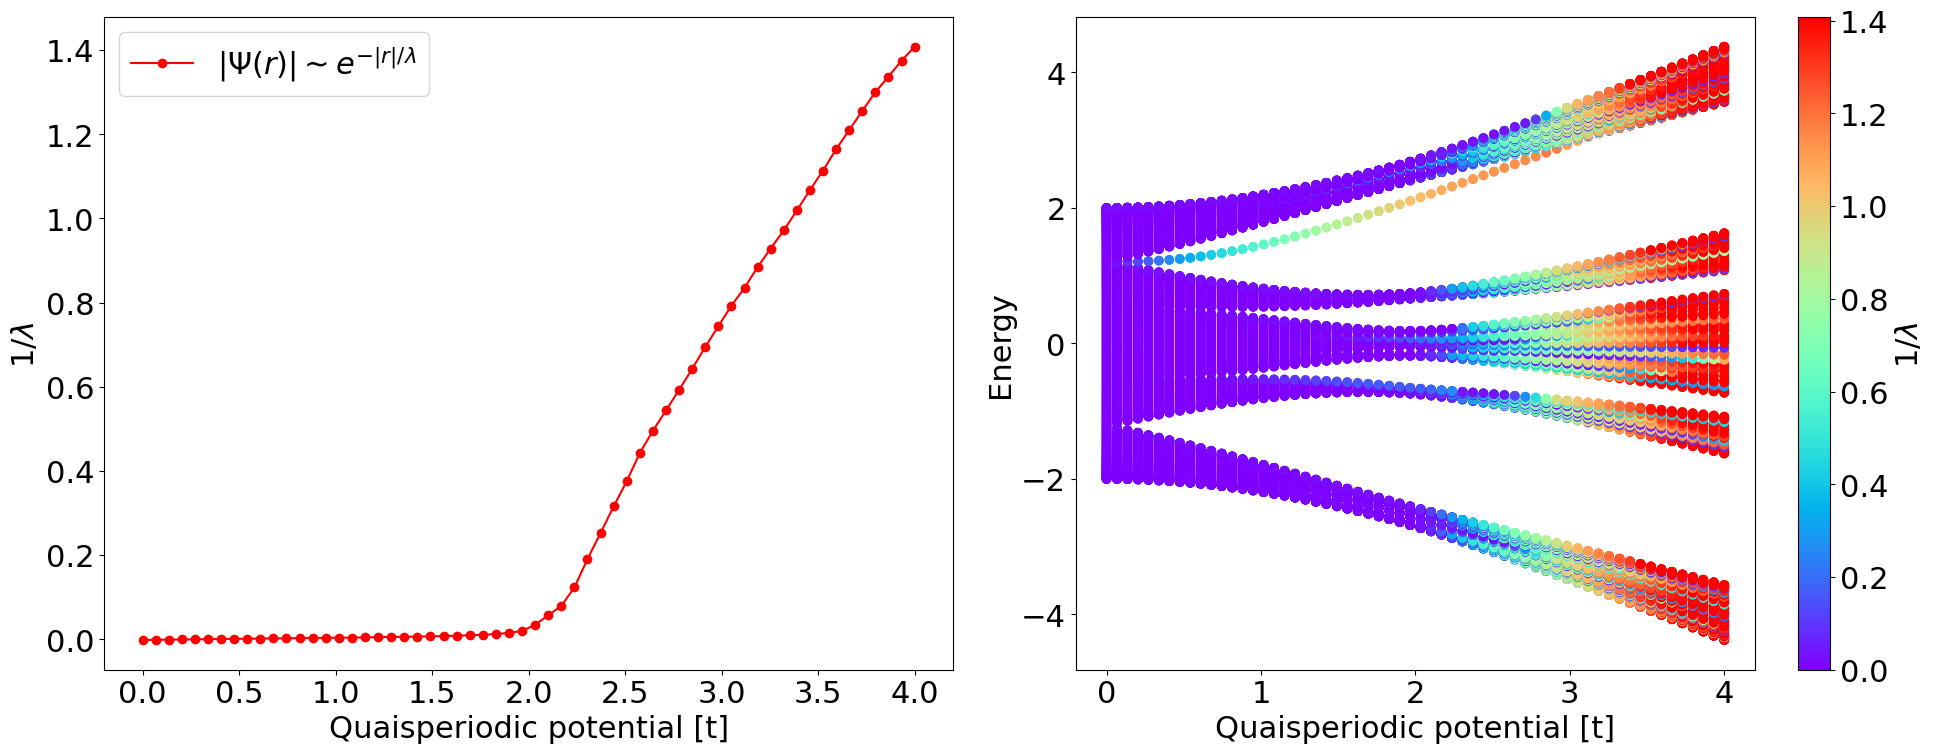

In [8]:

from pyqula import geometry
from pyqula import potentials
import numpy as np

g = geometry.chain(400) # chain
g.dimensionality = 0
vs = np.linspace(0.0,4.0,60) # potentials


lm = [] # empty array
larray = [] # empty array
earray = [] # empty array
varray = [] # empty array
for v in vs: # loop over strengths of the potential
    h = g.get_hamiltonian(has_spin=False) # get the Hamiltonian
    fun = lambda r: v*np.cos(np.sqrt(2)*np.pi*r[0]) # function with the quasiperiodic potential
    h.add_onsite(fun) # add onsite energies
    (es,ls) = h.get_tails() # return the localization length
    lm.append(np.mean(ls)) # store
    larray = np.concatenate([larray,ls]) # store localization lengths
    earray = np.concatenate([earray,es]) # store energies
    varray = np.concatenate([varray,es*0. + v]) # store potentials

import matplotlib.pyplot as plt
# now plot the average localization length as a function of the potential
plt.subplot(1,2,1)
plt.plot(vs,lm,marker="o",c="red",label="$|\\Psi(r)|\\sim e^{-|r|/\\lambda}$")
plt.legend() 
lmt = []
plt.xlabel("Quaisperiodic potential [t]")
plt.ylabel("$1/\\lambda$")

# now plot the localization length for each state
plt.subplot(1,2,2)
plt.scatter(varray,earray,marker="o",c=larray,cmap="rainbow",vmin=0,vmax=np.max(lm))
plt.ylabel("Energy")
plt.xlabel("Quaisperiodic potential [t]")
plt.colorbar(label="1/$\\lambda$")

plt.tight_layout()


### Quiz
- How do you know which states are localized and which ones are extended from the localization length $\lambda$?
- In the plot above, which states are localized?
- In the plots above, which states are delocallized?
- Can you observe a critical point where the states go from dellocalized to localized?
- Change the wavelength of the quasiperiodic potential, how does the previous picture change? 

## (Exercise) Localization due to random disorder
Here we will see how states get localized in the presence of random disorder, leading to an Anderson insulator

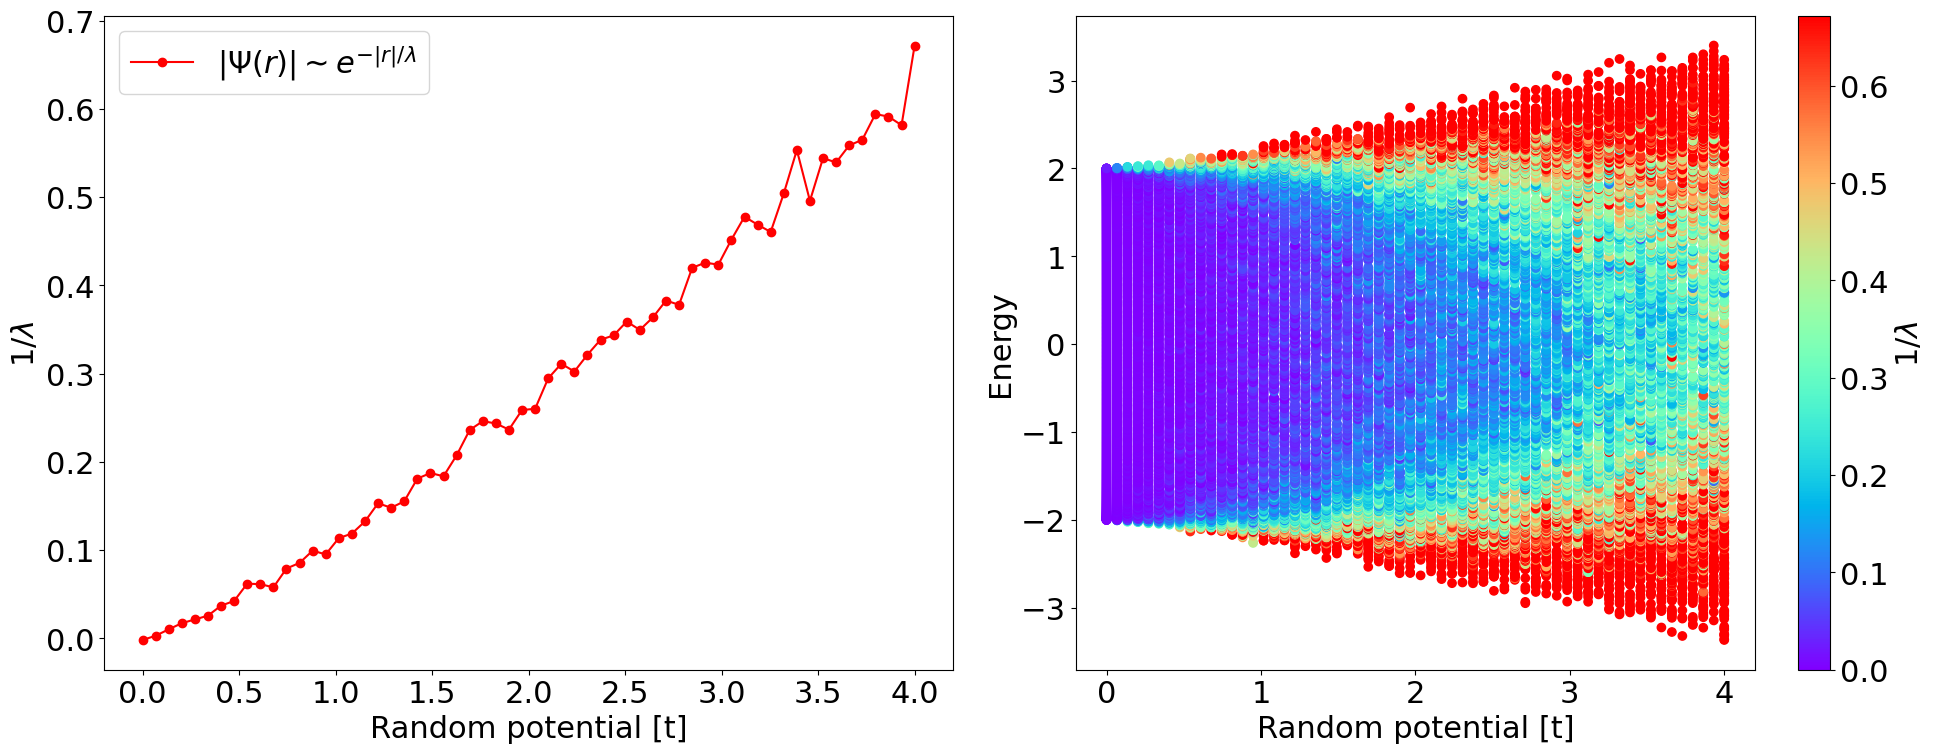

In [9]:

from pyqula import geometry
from pyqula import potentials
import numpy as np

g = geometry.chain(400) # chain
g.dimensionality = 0
vs = np.linspace(0.0,4.0,60) # potentials


lm = [] # empty array
larray = [] # empty array
earray = [] # empty array
varray = [] # empty array
for v in vs: # loop over strengths of the potential
    h = g.get_hamiltonian(has_spin=False) # get the Hamiltonian
    fun = lambda r: v*(np.random.random()-0.5) # function with the random potential
    h.add_onsite(fun) # add onsite energies
    (es,ls) = h.get_tails() # return the localization length
    lm.append(np.mean(ls)) # store
    larray = np.concatenate([larray,ls]) # store localization lengths
    earray = np.concatenate([earray,es]) # store energies
    varray = np.concatenate([varray,es*0. + v]) # store potentials

import matplotlib.pyplot as plt
# now plot the average localization length as a function of the potential
plt.subplot(1,2,1)
plt.plot(vs,lm,marker="o",c="red",label="$|\\Psi(r)|\\sim e^{-|r|/\\lambda}$")
plt.legend() 
lmt = []
plt.xlabel("Random potential [t]")
plt.ylabel("$1/\\lambda$")

# now plot the localization length for each state
plt.subplot(1,2,2)
plt.scatter(varray,earray,marker="o",c=larray,cmap="rainbow",vmin=0,vmax=np.max(lm))
plt.ylabel("Energy")
plt.xlabel("Random potential [t]")
plt.colorbar(label="1/$\\lambda$")

plt.tight_layout()


### Quiz
- How do you know which states are localized and which ones are extended from the localization length $\lambda$?
- Which states are the most localized?
- From the plot in the left, what is the minimal disorder to localized the states?
- Which type of material is the system in the presence of disorder?

## (Exercise) Non-magnetic impurities in a topological superconductor

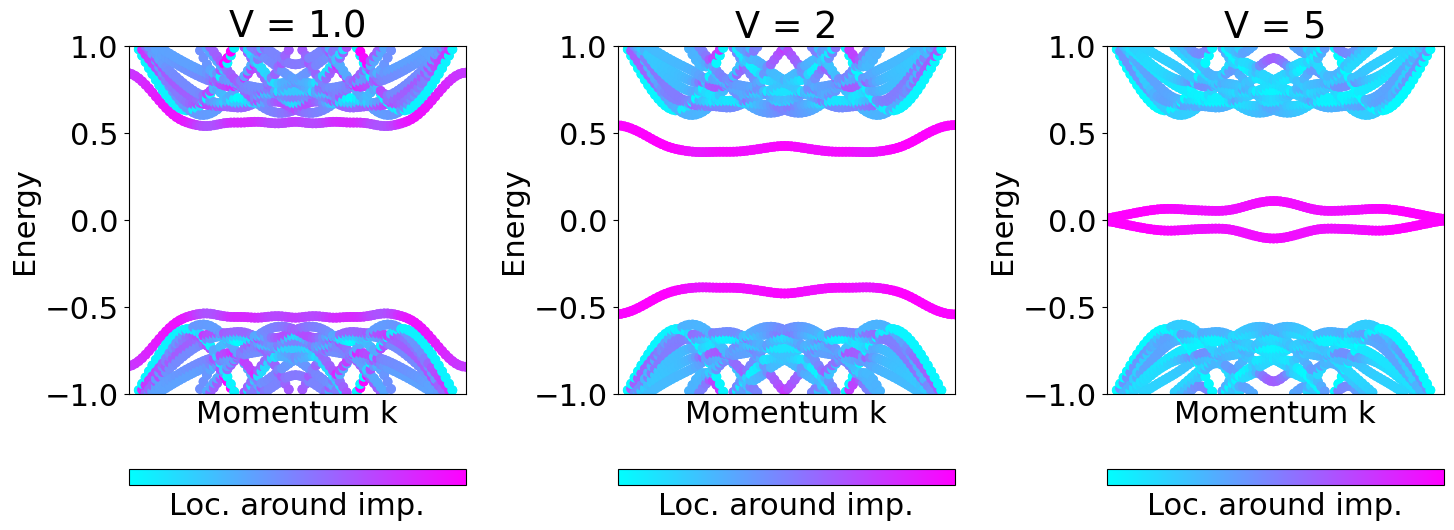

In [10]:
from pyqula import geometry, potentials
g = geometry.triangular_lattice() # take a triangular lattice
N = 7
g = g.get_supercell(N) # make a supercell
h = g.get_hamiltonian() # generate Hamiltonian
delta = 2e-1 # pairing
h.add_pairing(mode="chiral_pwave",delta=delta) # add pwave superconductivity
#h.add_pairing(mode="swave",delta=2*delta) # add swave superconductivity 
fig = plt.figure(figsize=(15,6))



pot = potentials.impurity(g.r[0],v=1.0) # potential for an impurity
nns = g.get_connections()[0] # get NN of site 0
NNpot = sum([potentials.impurity(g.r[i],v=1.0) for i in nns]) # potential for an impurity

# redefine the operator so that electron and hole componetns contribute equally
NNpot = h.get_operator(NNpot)*h.get_operator("electron") - h.get_operator(NNpot)*h.get_operator("hole")

def plot_bands(h):
    (ks,es,cs) = h.get_bands(operator=NNpot,nk=100)
    ewin = 1. # energy window to plot
    es,ks,cs = es[np.abs(es)<ewin],ks[np.abs(es)<ewin],cs[np.abs(es)<ewin]
    plt.scatter(ks,es,c=cs,cmap="cool")
    plt.ylabel("Energy") ; plt.xlabel("Momentum k") 
    plt.colorbar(ticks=[],label="Loc. around imp.",orientation="horizontal")
    plt.ylim([-ewin,ewin]) ; plt.xticks([]) ; plt.xlim([min(ks),max(ks)])
    
vs = [1.,2,5] # impurity potentials
nv = len(vs)
iv = 0
for v in vs:
    hi = h.copy() # make a copy
    hi.add_onsite(v*pot) # add impurity potential
    plt.subplot(1,nv,iv+1) ; iv += 1 ; plt.title("V = "+str(v))
    plot_bands(hi) # make the plot

plt.tight_layout()

### Quiz
- Which one of the bands is the impurity band?
- Make the supercell smaller. What do you see and why?
- Make the supercell bigger. What do you observa and why?
- Replace the pwave superconductivity by swave superconductivity. What do you observe and why?

## (Exercise) DOS of non-magnetic impurities in a topological superconductor
Here we will see how vacancies in a topological superconductor gives rise to an in-gap mode. We will take a big unit cell, and put a vacancy on it

<Figure size 2000x800 with 0 Axes>

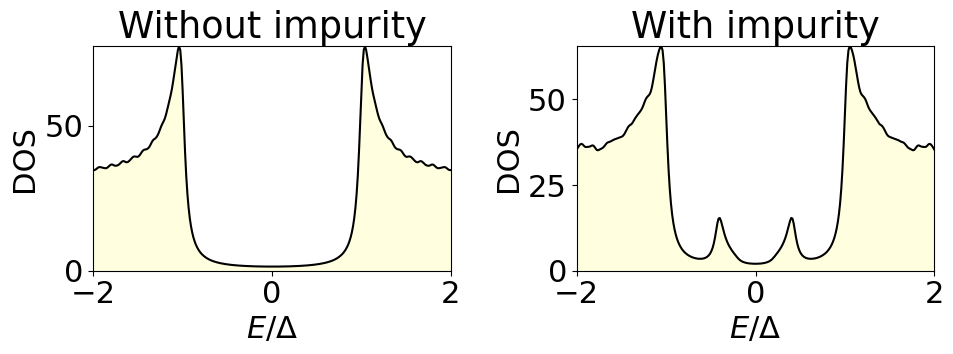

In [11]:
from pyqula import geometry, potentials, embedding
g = geometry.triangular_lattice() # take a triangular lattice
N = 10 # supercell where the impurity is put
h = g.get_hamiltonian() # generate Hamiltonian
h.add_onsite(-2.0) # shift the chemical potential
delta = 2e-1 # superconducting order parameter (very small to have nearly constant DOS in the energy window)
h.add_pairing(mode="chiral_pwave",delta=delta) # add topological superconductivity 
h = h.get_supercell(N) # make a supercell so that we have several sites per unit cell
h0 = h.copy() # make copy
h.add_onsite(potentials.impurity(h.geometry.r[0],v=4.0)) # add a strong non-magnetic impurity

fig = plt.figure(figsize=(20,8))

gap = h0.get_gap()/2. # compute the gap
#gap = 1.0
energies = np.linspace(-2*gap,2*gap,301) # energy grid



def plot_dos(h):
    (e,d) = h.get_dos(energies=energies,delta=gap/20,nk=20) # compute DOS
    e = e/gap # redefine
    plt.plot(e,d,c="black") ; plt.xlabel("$E/\\Delta$") ; plt.ylabel("DOS") # plot
    plt.fill_between(e, d, where=d>=d, interpolate=True, color='lightyellow') # add a background
    dmax = np.max(d)
    plt.xlim([min(e),max(e)]) ; plt.ylim([0,dmax])

    # first the pristine
fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1) ; plt.title("Without impurity")
plot_dos(h0)
# create an embedding object (infinite pristine system with h, central impurity hv)
plt.subplot(1,2,2) ; plt.title("With impurity")
plot_dos(h)


plt.tight_layout()

### Quiz
- Why do we have an ingap state with a non-magnetic impurity for a chiral pwave superconductor?
- Replace the non-magnetic impurity by a magnetic impurity, do we still have the in-gap state? Why?

## (Exercise) Single vacancy in a topological superconductor
Here we will see how a vancacy in a topological superconductor gives rise to an in-gap mode

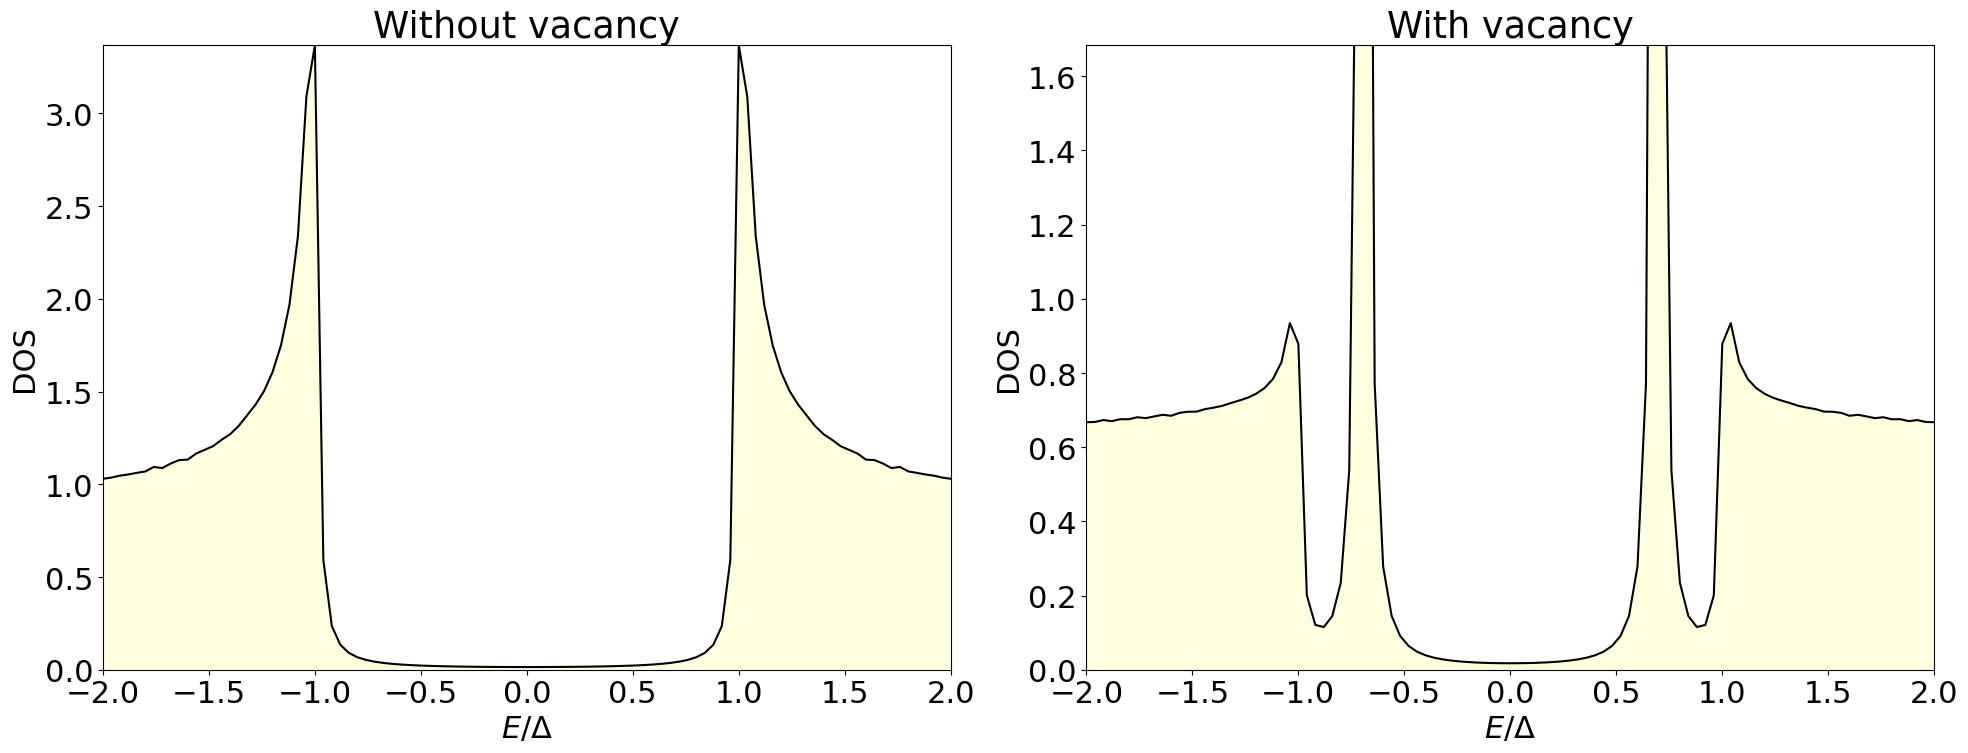

In [12]:
from pyqula import geometry, potentials, embedding
g = geometry.triangular_lattice() # take a triangular lattice
g = g.get_supercell((2,2)) # make a supercell so that we have several sites per unit cell
h = g.get_hamiltonian() # generate Hamiltonian
h.add_onsite(-4.0) # shift the chemical potential
delta = 1e-1 # superconducting order parameter
h.add_pairing(mode="chiral_pwave",delta=delta) # add topological superconductivity 
#h.add_pairing(mode="swave",delta=delta) # add trivial superconductivity 

fig = plt.figure(figsize=(20,8))

gap = h.get_gap()/2. # compute the gap

hv = h.copy() # make a copy
hv.add_onsite(potentials.impurity(g.r[0],v=100.0)) # unit cell with a strong non-magnetic impurity

# first the pristine
plt.subplot(1,2,1) ; plt.title("Without vacancy")
eb = embedding.Embedding(h,m=h) 
energies = np.linspace(-2*gap,2*gap,101) # energy grid
(e,d) = eb.multidos(es=energies,delta=gap/60,nk=400) # compute DOS
e = e/gap # redefine
plt.plot(e,d,c="black") ; plt.xlabel("$E/\\Delta$") ; plt.ylabel("DOS") # plot
plt.fill_between(e, d, where=d>=d, interpolate=True, color='lightyellow') # add a background
dmax = np.max(d)
plt.xlim([min(e),max(e)]) ; plt.ylim([0,dmax])

# create an embedding object (infinite pristine system with h, central impurity hv)
plt.subplot(1,2,2) ; plt.title("With vacancy")
eb = embedding.Embedding(h,m=hv) 
(e,d) = eb.multidos(es=energies,delta=gap/60,nk=400) # compute LDOS
e = e/gap # redefine
plt.plot(e,d,c="black") ; plt.xlabel("$E/\\Delta$") ; plt.ylabel("DOS") # plot
plt.fill_between(e, d, where=d>=d, interpolate=True, color='lightyellow') # add a background
plt.xlim([min(e),max(e)]) ; plt.ylim([0,dmax/2])

plt.tight_layout()

### Quiz
- Why does an in-gap mode appear when you include a very strong impurity?
- Replace the topological gap by a trivial gap (add_pairing(mode="swave")). What happens with the impurity state?

## (Exercise) Vacancies in a topological insulator

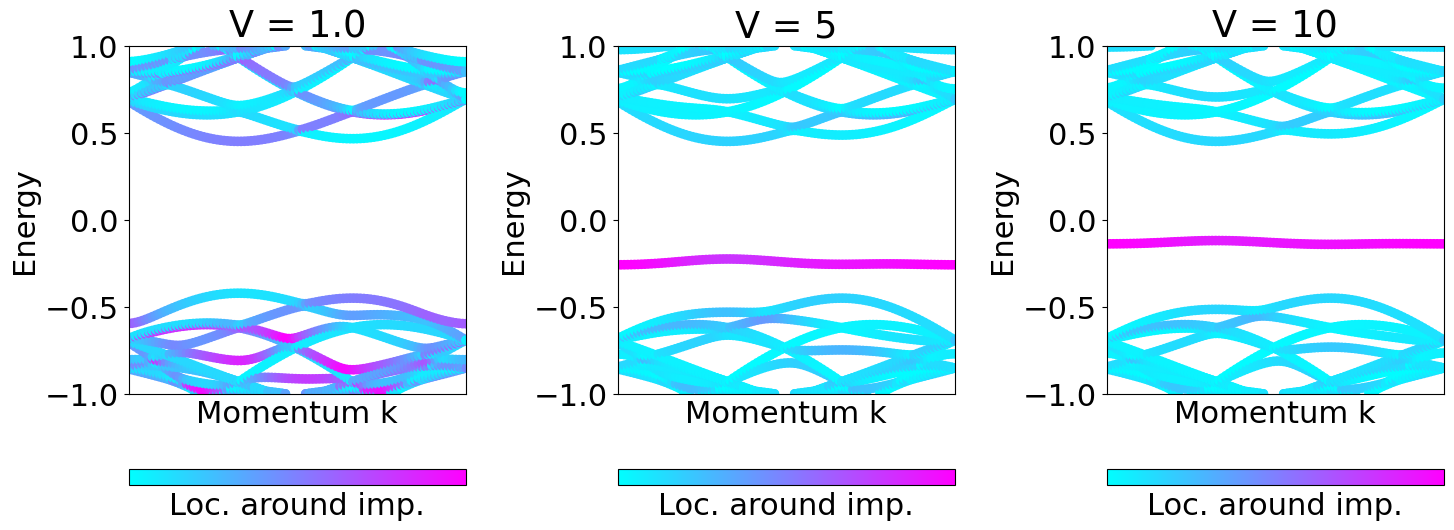

In [13]:
from pyqula import geometry, potentials, embedding
g = geometry.honeycomb_lattice() # take a triangular lattice
N = 7
g = g.get_supercell(N) # make a supercell
h = g.get_hamiltonian(has_spin=False) # generate Hamiltonian
h.add_haldane(0.1) # add a topological gap
#h.add_sublattice_imbalance(0.4) # trivial gap

fig = plt.figure(figsize=(15,6))

#gap = h.get_gap()/2. # gap of the system


hv = h.copy() # make a copy
pot = potentials.impurity(g.r[0],v=1.0) # potential for an impurity
nns = g.get_connections()[0] # get NN of site 0
NNpot = sum([potentials.impurity(g.r[i],v=1.0) for i in nns]) # potential for an impurity

def plot_bands(h):
    (ks,es,cs) = h.get_bands(operator=NNpot,nk=100)
    ewin = 1. # energy window to plot
    es,ks,cs = es[np.abs(es)<ewin],ks[np.abs(es)<ewin],cs[np.abs(es)<ewin]
    plt.scatter(ks,es,c=cs,cmap="cool")
    plt.ylabel("Energy") ; plt.xlabel("Momentum k") 
    plt.colorbar(ticks=[],label="Loc. around imp.",orientation="horizontal")
    plt.ylim([-ewin,ewin]) ; plt.xticks([]) ; plt.xlim([min(ks),max(ks)])
    
vs = [1.,5,10] # impurity potentials
nv = len(vs)
iv = 0
for v in vs:
    hi = h.copy() # make a copy
    hi.add_onsite(v*pot) # add impurity potential
    plt.subplot(1,nv,iv+1) ; iv += 1 ; plt.title("V = "+str(v))
    plot_bands(hi) # make the plot

plt.tight_layout()

### Quiz
- Which one of the bands is the impurity band?
- Make the supercell smaller. What do you see and why?
- Make the supercell bigger. What do you observa and why?

## (Exercise) Single vacancy in a topological insulator
Here we will see how a vacancy in a topological insulator creates an in-gap state

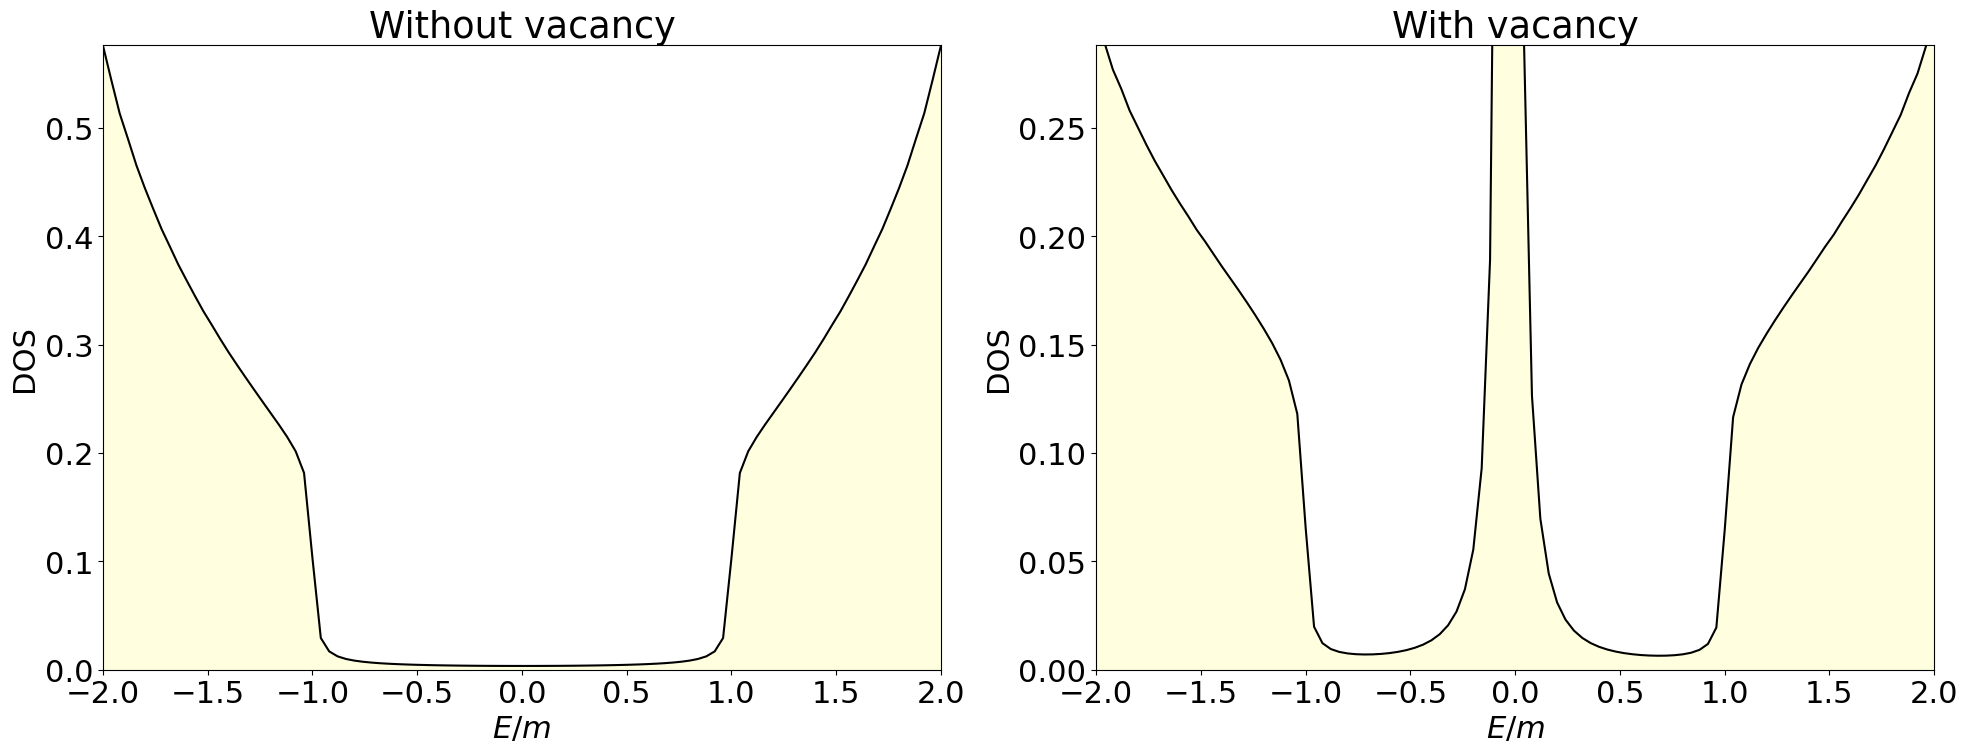

In [14]:
from pyqula import geometry, potentials, embedding
g = geometry.honeycomb_lattice() # take a triangular lattice
h = g.get_hamiltonian(has_spin=False) # generate Hamiltonian
h.add_haldane(0.1) # add a topological gap
#h.add_sublattice_imbalance(0.4) # trivial gap

fig = plt.figure(figsize=(20,8))

gap = h.get_gap()/2. # gap of the system


hv = h.copy() # make a copy
hv.add_onsite(potentials.impurity(g.r[0],v=100.0)) # unit cell with a strong non-magnetic impurity

# first the pristine
plt.subplot(1,2,1) ; plt.title("Without vacancy")
eb = embedding.Embedding(h,m=h) 
energies = np.linspace(-2*gap,2*gap,101) # energy grid
(e,d) = eb.multidos(es=energies,delta=gap/60,nk=400) # compute DOS
e = e/gap # redefine
plt.plot(e,d,c="black") ; plt.xlabel("$E/m$") ; plt.ylabel("DOS") # plot
plt.fill_between(e, d, where=d>=d, interpolate=True, color='lightyellow') # add a background
dmax = np.max(d)
plt.xlim([min(e),max(e)]) ; plt.ylim([0,dmax])

# create an embedding object (infinite pristine system with h, central impurity hv)
plt.subplot(1,2,2) ; plt.title("With vacancy")
eb = embedding.Embedding(h,m=hv) 
(e,d) = eb.multidos(es=energies,delta=gap/60,nk=400) # compute LDOS
e = e/gap # redefine
plt.plot(e,d,c="black") ; plt.xlabel("$E/m$") ; plt.ylabel("DOS") # plot
plt.fill_between(e, d, where=d>=d, interpolate=True, color='lightyellow') # add a background
plt.xlim([min(e),max(e)]) ; plt.ylim([0,dmax/2.])

plt.tight_layout()

### Quiz
- Why does an in-gap mode appear when you include a very strong impurity?
- Replace the topological gap by a trivial gap (add_sublattice_imbalance). What happens with the impurity state?